In [2]:
import numpy as np
import matplotlib.pyplot as plt

原理和思想讲解查看文档：
    一维伯格斯方程-时间和空间离散
    TVD-有限差分方法核心概念全解

解数据已保存到 'burgers_shock_solution.npz' 文件中。


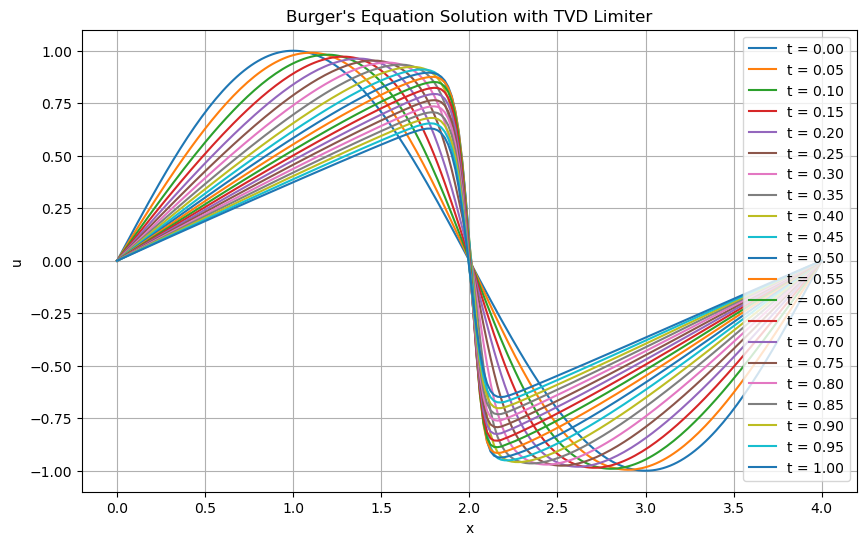

In [3]:
def tvd_flux_limiter(r, psi_type='superbee'):
    """
    TVD通量限制器函数。
    这个函数的核心作用是根据局部解的平滑程度来调整通量的修正量。
    
    参数:
    r (numpy.ndarray): 相邻梯度比率，r_i = (u_i - u_{i-1}) / (u_{i+1} - u_i)。
                       这个比率是判断当前区域是平滑（r接近1）还是存在激波（r接近0或很大）的关键指标。
    psi_type (str): 限制器类型，如 'superbee'。不同的限制器有不同的性能特点。
    
    返回:
    numpy.ndarray: 限制器函数 psi(r) 的值，其值在0到1之间。
                   在平滑区域，psi(r) 接近1，允许使用高阶格式；
                   在激波区域，psi(r) 接近0，退化为低阶格式以保证稳定性。
    """
    if psi_type == 'superbee':
        # Superbee 限制器以其锐利的激波捕捉能力而闻名。
        # 它在平滑区域倾向于1，在激波区域则为0。
        return np.maximum(0, np.maximum(np.minimum(1, 2 * r), np.minimum(r, 2)))
    # 可以添加其他限制器，例如 'minmod'
    # elif psi_type == 'minmod':
    #     return np.maximum(0, np.minimum(1, r))
    else:
        # 如果没有指定有效的限制器，默认返回1，相当于不进行限制，完全使用高阶格式
        return np.ones_like(r)

def calculate_gradient_ratio(u):
    """
    计算相邻梯度比率 r。
    该函数是通量限制器工作的第一步，用于生成限制器所需的输入参数。
    
    参数:
    u (numpy.ndarray): 当前时刻的解数组。
    
    返回:
    numpy.ndarray: 梯度比率 r 的数组。
    """
    # 使用numpy的切片操作进行向量化计算，提高效率
    # u_diff_forward 是 (u_{i+1} - u_i)
    u_diff_forward = u[2:] - u[1:-1]
    # u_diff_backward 是 (u_i - u_{i-1})
    u_diff_backward = u[1:-1] - u[:-2]
    
    # 避免除以零的错误，使用np.where在分母为0时返回0.0
    with np.errstate(divide='ignore', invalid='ignore'):
        r = np.where(u_diff_backward != 0, u_diff_forward / u_diff_backward, 0.0)
    
    return r

def calculate_convective_flux(u, dt, dx, psi):
    """
    计算并修正对流通量 F。
    该函数根据 TVD 格式的通量差分形式来构建最终的通量，是求解器中最重要的部分之一。
    
    参数:
    u (numpy.ndarray): 当前时刻的解数组。
    dt (float): 时间步长。
    dx (float): 空间步长。
    psi (numpy.ndarray): 通量限制器 psi(r) 的值，由tv_flux_limiter函数生成。
    
    返回:
    numpy.ndarray: 修正后的通量数组，代表了每个单元界面上的净通量。
    """
    nx = len(u)
    flux = np.zeros(nx - 1)
    
    for i in range(nx - 1):
        # 迎风速度 a，这里简化为u[i]
        a = u[i]
        
        # 低阶迎风通量，F_low = a * u_i
        flux_low = a * u[i] 
        
        # 高阶通量修正项 (F_{high} - F_{low})
        # F_high = F_low + correction_term
        # 这个修正项是基于高阶（如Lax-Wendroff）格式的，用于提高精度。
        correction_term = 0.5 * np.abs(a) * (1 - np.abs(a * dt / dx)) * (u[i+1] - u[i])
        
        # 引入通量限制器psi，只在i >= 1时应用
        # 在边界 i=0 时，没有 i-1 梯度比率，所以修正项为0
        limiter_value = psi[i-1] if i > 0 and i-1 < len(psi) else 0.0
        
        # 最终的通量 F = F_low + psi(r) * correction_term
        # 这是TVD格式的核心：在低阶通量基础上，根据限制器psi的值来调整高阶修正项的权重。
        flux[i] = flux_low + limiter_value * correction_term
        
    return flux

def stable_burgers_tvd_solver(nx=201, nt=400, L=4.0, dt=0.01, nu=0.01):
    """
    一个使用TVD限制器的更稳定的一维 Burger 方程求解器。
    该函数是整个模拟的主控函数，负责初始化、时间步进和调用其他函数。
    
    参数:
    nx (int): 空间网格点的数量。
    nt (int): 时间步的数量。
    L (float): 模拟区域的长度。
    dt (float): 时间步长。
    nu (float): 粘性系数，用于物理扩散。
    """
    dx = L / (nx - 1)
    x = np.linspace(0, L, nx)
    u = np.sin(2 * np.pi * x / L)

    results = {'t': [], 'u': []}

    for n in range(nt + 1):
        if n % 50 == 0:
            results['t'].append(n * dt)
            results['u'].append(u.copy())

        un = u.copy()
        
        # --- 求解对流项 ---
        # 1. 计算梯度比率 r，传递给限制器
        r = calculate_gradient_ratio(un)
        
        # 2. 计算通量限制器 psi 的值
        psi = tvd_flux_limiter(r)

        # 3. 计算界面通量 F_{i+1/2}，这是TVD格式的核心
        flux = calculate_convective_flux(un, dt, dx, psi)

        # --- 4. 求解扩散项 ---
        # 仍然使用二阶中心差分，因为它稳定且精度高
        diffusion_term = np.zeros(nx)
        diffusion_term[1:-1] = nu * (un[2:] - 2 * un[1:-1] + un[:-2]) / dx**2
        
        # --- 5. 整合并更新 u ---
        # 这里使用通量差分形式进行更新，满足物理守恒律。
        for i in range(1, nx - 1):
            # u_i^{n+1} = u_i^n - (dt/dx) * (F_{i+1/2} - F_{i-1/2}) + dt * diffusion_term
            u[i] = un[i] - (dt / dx) * (flux[i] - flux[i-1]) + dt * diffusion_term[i]
    
    # 将最终的解数据打包保存到 npz 文件
    # 'x', 't', 'u' 是保存数据时的键名
    np.savez('burgers_shock_solution.npz', x=x, t=results['t'], u=results['u'])
    print("解数据已保存到 'burgers_shock_solution.npz' 文件中。")
    return results

def plot_results(results):
    """
    绘制结果的函数。
    该函数负责将求解器返回的数据可视化，以便观察模拟结果。
    """
    plt.figure(figsize=(10, 6))
    for i, t in enumerate(results['t']):
        plt.plot(np.linspace(0, 4, 201), results['u'][i], label=f't = {t:.2f}')

    plt.xlabel('x')
    plt.ylabel('u')
    plt.title("Burger's Equation Solution with TVD Limiter")
    plt.legend()
    plt.grid(True)
    plt.show()

# 调用求解器并绘制结果
results = stable_burgers_tvd_solver(nx=201,nu=0.07, nt=1000, dt=0.001)
plot_results(results)